# Proyecto 4



El desarrollo de este notebook es la continuanción del trabajo realizado en este otro notebook https://github.com/pelandrun/acamica/blob/main/proyecto_acamica_03v01.ipynb. Durante el desarrollo del notebook mencionado nos encontramos con diferentes dificultades, la mayoría de las mismas devenida de la calidad del dataset, las cuales están documentadas en el análisis del trabajo anterior.

Como resultado del sistema de recomendación del trabajo anterior nos encontramos que el contenido de las recomendaciones como el orden era casi idéntico para todos los usuarios, quizá como resultado de la métrica y metodo que elegimos para generar el valor de la reseña.

Durante el desarrollo de este notebook intentaremos generar esta valoración de la reseña utilizando un enfoque distinto, en este caso, el sentimiento de las reseñas hacía ese juego o producto y así generar recomendaciones más variadas y personalizadas.

---

Composición de la calificación de la reseña:

1 punto para los negativos

2 puntos para los mixtos o con pocos reviews

3 puntos para los positivos

1 punto si el juego fue comprado: generalmente una persona que desembolsa dinero es, por que tiene expectativas, por que jugó un demo y le gustó, o por que lo quiere jugar con amigos. Salvo la expectativa, que puede ser defraudada, las otras dos razones son un indicador fuerte de que el juego es de su agrado.

Horas jugadas: esta vez será un 1 punto o 0 puntos dependiendo a las horas que jugó. Quizá esta vez valga la pena eliminar los valores atípicos, sobre todo los valores del extremo de la derecha.

De esta forma tendremos nuevamente una calificacion de 1 a 5 y formar una matriz con la que poder entrenar a los algoritmos de surprise.


## Inicializacio

### Imports

In [ ]:
import os
from time import time 
import numpy as np
import gzip
import sys
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Variables

In [ ]:
basepath="/content/drive/My Drive/Colab Notebooks/acamica_p03/"
datapath=basepath+"Datasets/"
steam_reviews_file=datapath+"steam_reviews.json.gz"
steam_games_file=datapath+"steam_games.json.gz"
steam_games_parquet=datapath+"steam_games.parquet"
steam_reviews_parquet=datapath+"steam_reviews.parquet"
verbose=3
random_state=1
np.random.seed(random_state)

### Funciones

In [ ]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

Esta funcion carga lee del archivo gzip un numero x de filas y las incorpora las incorpora al dataset despues de haber eliminado columnas que no son de interes.

In [ ]:
def load_reviews_from_gzip(file,n_lines=10):  
  """
  Carga el dataset en el formato dado, y genera un dataset solo con las columnas de interes
  
  Parameters
  ----------
  file: archivo 
  n_lines: cada cuantas lineas se genera el dataset
  """
  contador = 1
  data = []
  tmp_df=pd.DataFrame()
  data_reviews=pd.DataFrame()
  # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
  # abrira uno de cada tres, y asi.
  for l in parse(file):
    data.append(l)
    if contador%n_lines == 0:
      start = time()
      tmp_df=tmp_df.append(
          pd.DataFrame(data).drop(columns=['page_order','text','early_access','page','found_funny']),
          ignore_index=True)
      data_reviews=data_reviews.append(tmp_df, ignore_index=True)
      tmp_df=pd.DataFrame()
      # display(data_reviews)
      print('Lineas:'+str(contador)+' datalen: '+str(len(data)),end='')
      data=[]
      #print('time: '+str(int(time()-start)))
    contador += 1

  tmp_df=tmp_df.append(pd.DataFrame(data), ignore_index=True)
  tmp_df=tmp_df[['username','hours','products','product_id','date','user_id']]
  data_reviews=data_reviews.append(tmp_df, ignore_index=True)
  tmp_df=pd.DataFrame()
  # display(data_reviews)
  print('Lineas:'+str(contador)+' datalen: '+str(len(data)),end='')
  data=[]
  print('filas cargadas: '+str(data_reviews.shape[0]))
  return data_reviews

Remplaza el contenido de la columna username por el de la columna user_id en aquella donde exista user_id, ademas maraca la fila, para poder identificarla.

In [ ]:
def replace_usernamebyuser_id(data):
  """
  Cuando remplaza la variable username por user_id cuando user_id!=nan
  
  Parameters
  ----------
  data: dataframe de reviews
  """
  mask=(~data.user_id.isna())
  data.loc[mask,'username']=data[mask]['user_id']
  data['user_reset']=0;
  data.loc[mask,'user_reset']=1
  replaced=data[data.user_reset==1].shape[0]
  print('username remplazados:'+str(replaced)+' % del total:'+str(replaced/data.shape[0]*100))
  return data

In [ ]:
def drop_duplicate(data):
  """
  Dropea duplicados
  
  Parameters
  ----------
  data: dataframe de reviews
  """
  mask=data.duplicated(keep='first')
  duplicated=data[mask].shape[0]
  print('duplicados: '+str(duplicated)+' % del total:'+str(duplicated/data.shape[0]*100))
  return data[~mask]

Elimina las filas con products en nan. Esto es necesario, dado que para poder crear usuarios univocos, concatenamos username+products

In [ ]:
def clean_products_nan(data):
  """
  Elimina las filas que con user_id=nan y products=nan
  
  Parameters
  ----------
  data: dataframe de reviews
  """
  mask=((data.user_reset==0) & (data.products.isna()))
  nans=data[mask].shape[0]
  print('products=NaN: '+str(nans)+' % del total:'+str(round(nans/data.shape[0]*100,2)))
  return data[~mask]

Concatena usename con procuts, generanod un id de usuario unico en la columna username

In [ ]:
def concat_usernameWproducts(data):
  """
  Genera username univoco concatenando username+products cuando no exista user_id
  
  Parameters
  ----------
  data: dataframe de reviews
  """
  mask=(data.user_reset==0)
  newusername=data.loc[mask,'username']+'_'+data.loc[mask,'products'].astype(str)
  data.loc[mask,'username']=newusername
  print('Usernam modificados: '+str(mask.sum())+' % del total:'+str(round(mask.sum()/data.shape[0]*100,2)))
  return data

## Carga Dataset

Parcial

In [ ]:
#data_reviews=pd.read_parquet(steam_reviews_parquet)

In [ ]:
data_games = []
for l in parse(steam_games_file):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

Full

Intenta cargar el archivo parquet, si no existe lo genera cargando el archivo gzip y procesandolo con las funciones previamente declaradas.

In [ ]:
data_reviews_full_clean=datapath+"data_reviews_full_clean2.parquet"

In [ ]:
# try:
#   print ("Cargo dataset cache")
#   data_reviews=pd.read_parquet(data_reviews_full_clean,columns=['username','hours','date','compensation','product_id'])
# except NameError:
#   print('Salvo en cache')
#   print('Salvo en cache')
#   data_reviews=load_reviews_from_gzip(steam_reviews_file,n_lines=500000)
#   data_reviews=replace_usernamebyuser_id(data_reviews)
#   data_reviews=drop_duplicate(data_reviews)
#   data_reviews=clean_products_nan(data_reviews)
#   data_reviews=concat_usernameWproducts(data_reviews)
#   data_reviews.drop(columns=['user_id','user_reset','products'],inplace=True)
#   data_reviews[['username','hours','date','compensation','product_id']].to_parquet(data_reviews_full_clean)

In [ ]:
if os.path.isfile(data_reviews_full_clean):
  print ("Cargo dataset cache")
  data_reviews=pd.read_parquet(data_reviews_full_clean,columns=['username','hours','date','compensation','product_id'])
else:
  print('Salvo en cache')
  data_reviews=load_reviews_from_gzip(steam_reviews_file,n_lines=500000)
  data_reviews=replace_usernamebyuser_id(data_reviews)
  data_reviews=drop_duplicate(data_reviews)
  data_reviews=clean_products_nan(data_reviews)
  data_reviews=concat_usernameWproducts(data_reviews)
  data_reviews.drop(columns=['user_id','user_reset','products'],inplace=True)
  data_reviews[['username','hours','date','compensation','product_id']].to_parquet(data_reviews_full_clean)

Cargo dataset cache


In [ ]:
display(data_reviews)
display(data_reviews.shape)
display(data_reviews.info())
display(data_reviews.describe())

,username,hours,date,compensation,product_id
0,Chaos Syren_41.0,0.1,2017-12-17,None,725280
1,₮ʜᴇ Wᴀʀᴛᴏɴ_769.0,51.1,2017-12-27,None,328100
2,hello?<_2.0,14.6,2017-10-16,Product received for free,328100
3,Cyderine916_64.0,5.0,2018-01-04,None,35140
4,76561198007483075,16.6,2018-01-04,None,35140
...,...,...,...,...,...
7793055,Zezztah_200.0,591.3,2013-12-11,None,252490
7793056,niquarn_42.0,669.9,2013-12-11,None,252490
7793057,Kero_112.0,198.5,2013-12-11,None,252490
7793058,76561197962161824,2775.2,2013-12-11,None,252490


(6956733, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6956733 entries, 0 to 7793065
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   username      object 
 1   hours         float64
 2   date          object 
 3   compensation  object 
 4   product_id    object 
dtypes: float64(1), object(4)
memory usage: 318.5+ MB


None

,hours
count,6.930806e+06
mean,1.013662e+02
std,3.735244e+02
min,0.000000e+00
25%,3.600000e+00
50%,1.380000e+01
75%,5.240000e+01
max,4.210070e+04


### Eliminamos columnas que decidimos no utilizar

Conservamos del dataset de juegos price y sentiment, con ellas intentaremos reconstruir la valoración de las reseñas. 


In [ ]:
# data_reviews=data_reviews.drop(columns=['text','page_order','page','found_funny','user_id','early_access','products'])

In [ ]:
data_games=data_games[['id','title','price','sentiment']]

### Realizamos la unión de ambos dataset.

In [ ]:
data_reviews=data_reviews.merge(data_games[['id','price','sentiment']], right_on='id',left_on='product_id')
data_reviews.drop(columns=['id'],inplace=True)

## Limpiamos filas con valores faltantes en las variables de interes.

In [ ]:
pd.DataFrame(data_reviews.isna().sum().rename('NaN Count'))

,NaN Count
username,0
hours,25927
date,0
compensation,6832067
product_id,0
price,65169
sentiment,1319


#### Variable 'hours'

La variable hours es indispensable para poder dar una puntuación a las revisiones, por este motivo eliminamos aquellas filas nulas.

In [ ]:
mask=(data_reviews.hours.isna())
print('Eliminamos: ',mask.sum(),' filas.')
data_reviews=data_reviews[~mask].copy()

Eliminamos:  25927  filas.


#### Variable 'compensation'

In [ ]:
pd.DataFrame(data_reviews.compensation.value_counts())

,compensation
Product received for free,129899


Cuando esta presente, indica que el producto revisto no ha tenido costo para el usuario. Cuando es nulo indica que se pagó segun lo indica la columna price, que tambien pude indicar costo 0 (?).
Por lo tanto conservamos todas las filas.

#### Variable 'price'

In [ ]:
data_reviews

,username,hours,date,compensation,product_id,price,sentiment
0,Chaos Syren_41.0,0.1,2017-12-17,None,725280,2.99,Positive
1,Teef 🐏_923.0,0.9,2017-12-03,None,725280,2.99,Positive
2,nd_2759.0,1.0,2017-11-28,None,725280,2.99,Positive
3,Sneaky_Panda_243.0,0.6,2017-11-27,None,725280,2.99,Positive
4,76561198159791799,0.3,2017-11-13,None,725280,2.99,Positive
...,...,...,...,...,...,...,...
6962118,76561198191446302,1.3,2017-02-16,None,518790,29.99,Mostly Positive
6962119,Kulta-Jaska_23.0,330.2,2017-02-16,None,518790,29.99,Mostly Positive
6962120,76561198194088565,13.9,2017-02-16,None,518790,29.99,Mostly Positive
6962121,Proxwian_767.0,44.2,2017-02-16,None,518790,29.99,Mostly Positive


In [ ]:
mask=data_reviews.price.apply(lambda x: isinstance(x,float))

Price, cuando es string nos ofrece esta variedad de opciones. En casi todos lo caso leemos "Free", tratemos de ver que significan las demás.

In [ ]:
display(pd.DataFrame(data_reviews[~mask].price.value_counts().rename('count')))

,count
Free to Play,945083
Free,228255
Free To Play,108951
Free HITMAN™ Holiday Pack,8480
Play for Free!,5265
Free Movie,4814
Install Now,1230
Free Mod,864
Play WARMACHINE: Tactics Demo,804
Free to Use,500


In [ ]:
data_reviews[data_reviews.price=='Install Now']

,username,hours,date,compensation,product_id,price,sentiment
2785504,newabcd_35.0,1578.9,2018-01-05,None,268850,Install Now,Mostly Positive
2785505,Rucko_115.0,318.3,2018-01-04,None,268850,Install Now,Mostly Positive
2785506,chiken_43.0,242.6,2018-01-03,None,268850,Install Now,Mostly Positive
2785507,Lemons_100.0,12.0,2018-01-02,None,268850,Install Now,Mostly Positive
2785508,'-PlayeR.M.u.D-'_369.0,5.4,2018-01-02,None,268850,Install Now,Mostly Positive
...,...,...,...,...,...,...,...
2786729,SandWormJr_1100.0,0.6,2014-07-16,None,268850,Install Now,Mostly Positive
2786730,Weeddrunken_797.0,1.3,2014-07-16,None,268850,Install Now,Mostly Positive
2786731,SGM ツ_284.0,0.3,2014-07-16,None,268850,Install Now,Mostly Positive
2786732,glitchgod_513.0,2.3,2014-07-16,None,268850,Install Now,Mostly Positive


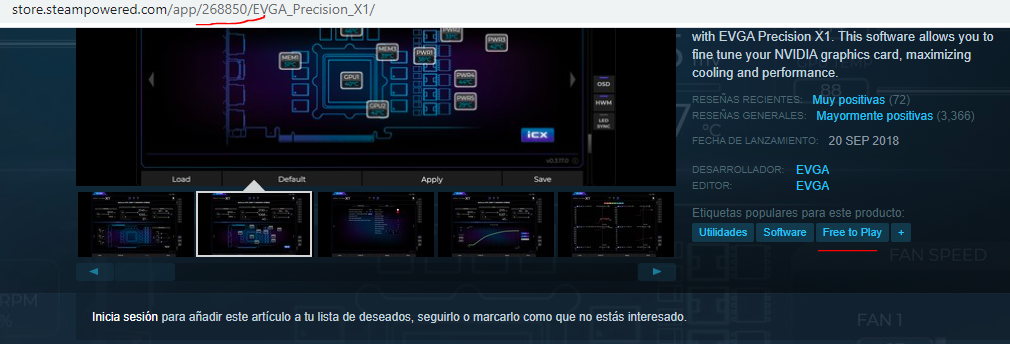

In [ ]:
data_reviews[data_reviews.price=='Third-party']

,username,hours,date,compensation,product_id,price,sentiment
4836613,76561198353623449,0.2,2017-12-26,None,3483,Third-party,Very Positive
4836614,You're all shit._22.0,1.4,2017-12-13,None,3483,Third-party,Very Positive
4836615,Trar [99th Calzones]_382.0,0.9,2017-12-08,None,3483,Third-party,Very Positive
4836616,76561198332675259,1.3,2017-12-03,None,3483,Third-party,Very Positive
4836617,76561198246227600,0.1,2017-12-02,None,3483,Third-party,Very Positive
...,...,...,...,...,...,...,...
4837060,Dor_136.0,1.3,2010-11-28,None,3483,Third-party,Very Positive
4837061,Vic=HKC=_2286.0,5.2,2010-11-25,None,3483,Third-party,Very Positive
4837063,AfroRyan_1196.0,2.6,2010-11-22,None,3483,Third-party,Very Positive
4837065,I'm that dude._1864.0,0.7,2010-11-20,None,3483,Third-party,Very Positive


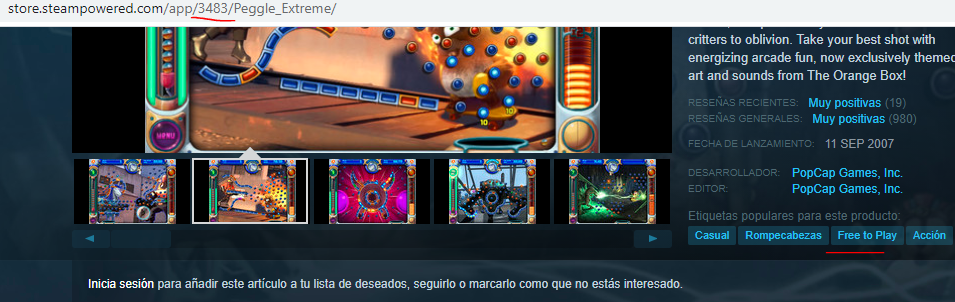

Buscamos en steam los que respondian a price igual a "Install Now" o "Third Party", y podemos ver que indican lo mismo, que el juego es gratis.

Cuando price es numérico:

In [ ]:
# display(pd.DataFrame(data_reviews[mask].desr()))
data_reviews[mask].price.astype(float).describe()

count    5.566552e+06
mean     1.967032e+01
std      1.619132e+01
min      4.900000e-01
25%      9.990000e+00
50%      1.699000e+01
75%      2.499000e+01
max      7.717100e+02
Name: price, dtype: float64

Bueno podemos ver que no hay ninguno con valor 0.

Vemos que casi todas son numéricas, y algun string.
Eliminamos los nulos y de este modo nos quedamos con aquellas en las que podemos determinar el precio.

In [ ]:
mask=data_reviews.price.isna()
print('Eliminamos: ',mask.sum(),' filas.')
data_reviews=data_reviews[~mask]

Eliminamos:  64758  filas.


### Variable 'sentiment'

Otra variable que importante en la formacion del puntaje del review, eliminamos los nulo.

In [ ]:
mask=data_reviews.sentiment.isna()
print('Eliminamos: ',mask.sum(),' filas.')
data_reviews=data_reviews[~mask]

Eliminamos:  838  filas.


Finalmente

In [ ]:
data_reviews.isna().sum()

username              0
hours                 0
date                  0
compensation    6741853
product_id            0
price                 0
sentiment             0
dtype: int64

Los únicos valores nulos que se conservan son los de la variable **compensation**, dado que tienene significado, cuando es null es que no es un producto adquirido como compensación, en caso contrario es una compensación.

## Rating

### Sentiment

In [ ]:
pd.DataFrame(pd.unique(data_reviews.sentiment)).sort_values(by=[0])

,0
9,1 user reviews
3,2 user reviews
10,3 user reviews
7,4 user reviews
14,5 user reviews
5,6 user reviews
16,7 user reviews
15,8 user reviews
13,9 user reviews
1,Mixed


Crearemos la variable sentiment_points, la inicializaremos en 2 que es el valor que tendran la mayor parte del dominio de sentiment

In [ ]:
data_reviews['sentiment_points']=2

Setearemos en 1, cuando sentiment sea igual a alguno de estos valores "Very Negative,Overwhelmingly Negative,Negative,Mostly Negative"

In [ ]:
mask=data_reviews.sentiment.isin(['Very Negative','Overwhelmingly Negative','Negative','Mostly Negative'])
data_reviews.loc[mask,'sentiment_points']=1

Setearemos en 3, cuando sentiment sea igual a alguno de estos valores "Very Positive,Positive,Overwhelmingly Positive,Mostly Positive"

In [ ]:
mask=data_reviews.sentiment.isin(['Very Positive','Positive','Overwhelmingly Positive','Mostly Positive'])
data_reviews.loc[mask,'sentiment_points']=3

### Puntos si pagó por el Juego

Crearemos la variable paid_points
La inicializamos en 0

In [ ]:
data_reviews['paid_points']=0

In [ ]:
# data_reviews.price.apply(lambda x: isinstance(x, float)).sum()+data_reviews.price.apply(lambda x: isinstance(x, str)).sum()

Si price es un numero, es mayor a 0 y compensation es distinto de None, entonces cosideramos que pago por el producto.

In [ ]:
mask=(data_reviews.price.apply(lambda x: isinstance(x, float)))
mask.sum()
mask=  (data_reviews[mask].price > 0)
print(mask.sum())
print((~data_reviews.compensation.isna()).sum())
mask = mask & (data_reviews.compensation.isna())
mask.sum()

5565715
128747


5449863

In [ ]:
data_reviews.loc[mask,'paid_points']=1

In [ ]:
data_reviews.isna().sum()

username                  0
hours                     0
date                      0
compensation        6741853
product_id                0
price                     0
sentiment                 0
sentiment_points          0
paid_points               0
dtype: int64

In [ ]:
data_reviews.sentiment_points.value_counts()

3    5663653
2    1113050
1      93897
Name: sentiment_points, dtype: int64

In [ ]:
data_reviews.paid_points.value_counts()

1    5449863
0    1420737
Name: paid_points, dtype: int64

In [ ]:
data_reviews[~data_reviews.price.apply(lambda x: isinstance(x, float))]

,username,hours,date,compensation,product_id,price,sentiment,sentiment_points,paid_points
16311,The Forgotten_84.0,2.8,2017-12-21,None,399660,Free to Play,Mixed,2,0
16312,Rapxtor_1597.0,59.7,2017-06-21,None,399660,Free to Play,Mixed,2,0
16313,♿ Svinhugg_298.0,0.2,2017-06-21,None,399660,Free to Play,Mixed,2,0
16314,ᵂᴬᴸᴸᴱᴿ ❤_179.0,2.5,2017-05-13,None,399660,Free to Play,Mixed,2,0
16315,skilled_dragon_25.0,0.8,2017-04-21,None,399660,Free to Play,Mixed,2,0
...,...,...,...,...,...,...,...,...,...
6958296,76561198015692280,0.0,2015-04-12,None,361700,Free,Very Positive,3,0
6958321,Revolt_267.0,0.7,2015-04-10,None,361700,Free,Very Positive,3,0
6958322,fajar_gobank_587.0,0.3,2015-04-10,None,361700,Free,Very Positive,3,0
6958328,76561198203850192,0.2,2015-04-07,None,361700,Free,Very Positive,3,0


### Hours

In [ ]:
data_reviews['hours_points']=0

#### Eliminamos los productos con menos de 10 reviews

Dado que los productos con menos de 10 revisiones no tienen asignado un valor para sentiment

In [ ]:
mask=data_reviews.groupby(['product_id']).product_id.transform('count')>=10
print(mask.sum())
data_reviews=data_reviews[mask].copy()

6854129


#### 1 punto para los que jugaron mas de la media

In [ ]:
mask=data_reviews.groupby(['product_id']).hours.transform('mean')>=data_reviews.hours
data_reviews.loc[mask,'hours_points']=1

In [ ]:
data_reviews['rating']=data_reviews.sentiment_points+data_reviews.paid_points+data_reviews.hours_points

In [ ]:
data_reviews.rating.value_counts()

5    3280043
4    2703870
3     779502
2      88202
1       2512
Name: rating, dtype: int64

### Estdisticos

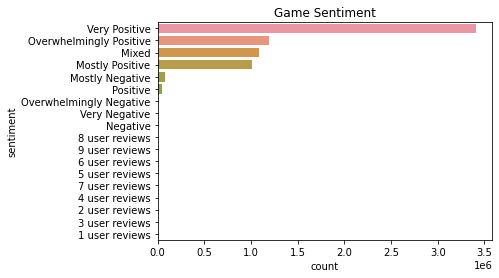

In [ ]:
chart= sns.barplot(y='index', x='count',
    data=pd.DataFrame(data_reviews.sentiment.value_counts().rename('count')).reset_index().sort_values(by=['count'],ascending=False)
    )
chart.set_ylabel('sentiment')
chart.set_title('Game Sentiment')
plt.show()

Podríamos decir que según este dataset los usuarios tienden a escribir una reseña cuando el juego es de su agrado.

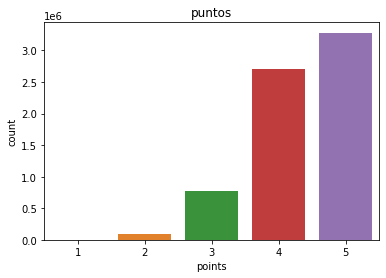

In [ ]:
chart= sns.barplot(x='index', y='count',
    data=pd.DataFrame(data_reviews.rating.value_counts().rename('count')).reset_index().sort_values(by=['count'],ascending=False)
    )
chart.set_ylabel('count')
chart.set_xlabel('points')
chart.set_title('puntos')
plt.show()

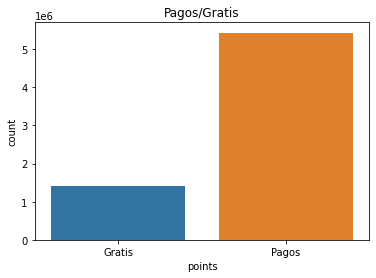

In [ ]:
chart= sns.barplot(x='index', y='count',
    data=pd.DataFrame(data_reviews.paid_points.value_counts().rename('count')).reset_index().sort_values(by=['count'],ascending=False)
    )
chart.set_ylabel('count')
chart.set_xlabel('points')
chart.set_title('Pagos/Gratis')
chart.set_xticklabels(['Gratis','Pagos'])
plt.show()

Pareciera que se tiende a reseñar más a los productos pagos que a los gratis.

In [ ]:
mask=data_games.price.apply(lambda x: isinstance(x, str))
pd.DataFrame({ 'Gratis': [mask.sum()], 'Pagos': [(~mask).sum()] })


,Gratis,Pagos
0,1910,30225


Pero parece que el tema es que hay más oferta de productos pagos que gratis.

## Modelo

In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 3.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617562 sha256=bbcac98b6baaacfac4a50a20d3050cee52a6ec04a8068694843c774bd16656c4
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD,SVDpp,SlopeOne,KNNBasic,NMF,KNNBaseline,BaselineOnly
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV
reader = Reader()

### Benchmark

Probamos algunos de los algoritmos que nos ofrece Surprice y comparamos los resultados. Dado el tamaño del dataset utilizamos un sampleo de algunas muestras.

In [ ]:
samples = .06 # cantidad de muestras del dataset de reviews
data_review_small=data_reviews.sample(frac=samples)
data = Dataset.load_from_df(data_review_small[['username', 'product_id','rating']], reader)


In [ ]:
print('Filas de la muestra:',data_review_small.shape[0])

Filas de la muestra: 411248


In [ ]:
%%time
algos = [SlopeOne(),SVD(),SVDpp(),NMF(),BaselineOnly()]
resultados=pd.DataFrame()
for algo in range(len(algos)):
  # algo=algos[i]
  algo=algos.pop()
  algo_name=algo.__class__.__name__
  print(algo_name)
  cv_result=cross_validate(algo, data,cv=3, measures=['rmse'], verbose = verbose )
  del(algo)
  print(cv_result)
  resultados=resultados.append({
      'Algo':algo_name,
      'RMSE':cv_result['test_rmse'].mean(),
      'RMSE std':cv_result['test_rmse'].std(),
      'fit_time':np.mean(cv_result['fit_time']),
      'test_time':np.mean(cv_result['test_time']),
      },
      ignore_index=True)
gc.collect()

BaselineOnly
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4840  0.4871  0.4828  0.4847  0.0018  
Fit time          2.69    2.83    2.92    2.81    0.10    
Test time         1.39    1.18    1.39    1.32    0.10    
{'test_rmse': array([0.48399956, 0.48713312, 0.48284439]), 'fit_time': (2.685405731201172, 2.8305001258850098, 2.9241888523101807), 'test_time': (1.3934845924377441, 1.1849555969238281, 1.3878304958343506)}
NMF
Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7757  0.7733  0.7717  0.7736  0.0017  
Fit time          42.14   41.51   41.60   41.75   0.28    
Test time         1.30    1.25    1.27    1.27    0.02    
{'test_rmse': array([0.77574205, 0.77327566, 0.77167468]), 'fit_time': (42.135892391204834, 41.510689973

Resutados del benchmark

In [ ]:
display(resultados.sort_values(by=['RMSE']))

,Algo,RMSE,RMSE std,fit_time,test_time
3,SVD,0.481394,0.000896,19.083420,1.268471
0,BaselineOnly,0.484659,0.001812,2.813365,1.322090
2,SVDpp,0.494020,0.000681,32.555702,1.604065
4,SlopeOne,0.762284,0.000755,5.163543,1.522316
1,NMF,0.773564,0.001673,41.749879,1.272383


SVD es el que nos muestra el menor RMSE, intentaremos mejorarlo buscando los mejores hiperparametros.

### Busqueda mejore parametros

In [ ]:
%%time
param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2], 'n_factors' : [5,50,100,150]}

gs_svd = GridSearchCV (SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1,joblib_verbose=3)

gs_svd.fit(data)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 81.5min


CPU times: user 1h 19min 54s, sys: 51.1 s, total: 1h 20min 45s
Wall time: 1h 36min 50s


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 96.8min finished


In [ ]:
# best RMSE score
print('Mejor RMSE: ',gs_svd.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print('Mejore parametroe: ',gs_svd.best_params['rmse'])

Mejor RMSE:  0.4777066678012953
Mejore parametroe:  {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.002, 'n_factors': 5}


La mejora obtenida con grid search es esta en el orde de una centecima de RMSE.

### Entrenanamiento

##### Validación cruzada, nuevamente.

Como buscamos los mejores parametros con una muestra del dataset, relizamos otra validación cruzada para determinar si se empeora o mejora el error ahora que trabajamos con el dataset completo.

In [ ]:
%%time
data = Dataset.load_from_df(data_reviews[['username', 'product_id','rating']], reader)
svd = SVD(n_epochs = 20, lr_all = 0.005, reg_all = 0.002, n_factors = 5,random_state = random_state)
cv_result=cross_validate(svd, data,cv=3, measures=['rmse'], verbose = verbose  )


Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4469  0.4475  0.4471  0.4472  0.0002  
Fit time          133.22  139.14  139.39  137.25  2.85    
Test time         34.50   29.04   32.91   32.15   2.29    
CPU times: user 10min 30s, sys: 10.2 s, total: 10min 41s
Wall time: 10min 43s


Con el dataset completo, el error mejoró un par de centecimas.

Entrenamiento final.

In [ ]:
samples=1
data_review_small=data_reviews
data = Dataset.load_from_df(data_review_small[['username', 'product_id','rating']], reader)
trainset = data.build_full_trainset()
# svd = SVD(n_epochs = 20, lr_all = 0.005, reg_all = 0.002, n_factors = 5,random_state = random_state)
svd.fit(trainset)

Catálogo de juegos

In [ ]:
catalogo=data_games[['id','title']].copy()

### Sitema de recomendación

##### FUNCION DE RECOMENDACION

In [ ]:
def recomienda_x_usename(username,data_reviews,catalogo,rating=0,top=5,offset=0):
  """
  Recomienda juegos

  Parameters
  ----------
  username: username

  data_reviews: dataset revisiones

  data_games: dataset juegos

  rating: el rating minimo que le tiene que haber otorgado a un titulo para la predicción

  top: cuantas recomendaciones devuelve la recomendación

  ofset: desplaza la recomendación descartando las primeras filas cantidad = offset
  """

  data_user = data_reviews[data_reviews.username==username][['username','product_id','rating']]
  data_user = data_user.reset_index(drop=True)
  recomedaciones=catalogo
  # elimino los productos evaluados por el usuario
  recomedaciones=recomedaciones[~recomedaciones.id.isin(data_user.product_id)].copy()
  # descarto los productos del usuario segun scope 
  data_user=data_user[data_user.rating >= rating]
  if (data_user.shape[0]==0):
    return False;
  recomedaciones['est_rating']=recomedaciones['id'].apply(lambda x: svd.predict(username, x).est)
  return recomedaciones.sort_values(by=['est_rating'],ascending=False).head(top+offset).tail(top).reset_index(drop=True)


In [ ]:
def reco(n_usuarios=20,top=5,n_offset=0,rating=5,random_state=None,data_reviews_2=False):
  """
  Realiza un test de sobre usuarios al azar, mostrando las recomendaciones y un pequeño resumen
  del resultado

  Parameters
  ----------
  n_usuarios: cantidad de usuarios de muestra

  top: número de recomendaciones por usuario ordenadas por raiting

  n_ofset: desplaza la recomendación descartando las primeras filas cantidad = offset

  rating: rating  mínimo del de los items del inventsario del usuari a tener en cuenta para las recomendaciones.

  random_state:

  data_reviews_2: dataset revisiones

  """
  np.random.seed(random_state)
  tmp=pd.DataFrame()
  for item in data_reviews_2.sample(n_usuarios).username:
    print(item,' ',end='')
    rec=recomienda_x_usename(item,data_reviews_2,catalogo,rating=rating,offset=n_offset,top=top)
    display(rec)
    if isinstance(rec,pd.DataFrame):
      tmp=tmp.append(rec)
  print('Cantidad de usuarios evaluados: ',n_usuarios)
  print('Cantidad total de recomendaciones esperadas: ',n_usuarios*top)
  print('Cantidad total de recomendaciones recividas: ',tmp.shape[0])
  t_recomendadas=pd.DataFrame(pd.unique(tmp.title))
  print('Cantidad de Juegos distintas: '+str(t_recomendadas.shape[0]))
  # display(t_recomendadas)
  return tmp


In [ ]:
tmp=reco(n_usuarios=10,top=10,n_offset=0,rating=0,data_reviews_2=data_reviews)

76561198101240026  

,id,title,est_rating
0,349260,BlastZone 2,5.0
1,393610,ROOT,5.0
2,313340,Mountain,5.0
3,202730,Dynamite Jack,5.0
4,270790,Etherlords II,5.0
5,273620,Freespace 2,5.0
6,251370,Escape Goat,5.0
7,472870,Higurashi When They Cry Hou - Ch.3 Tatarigoroshi,5.0
8,29160,Blueberry Garden,5.0
9,315810,eden*,5.0


Royce_1006.0  

,id,title,est_rating
0,246960,Giana Sisters: Twisted Dreams - Rise of the Ow...,5.0
1,316660,Toast Time,5.0
2,303680,FATE: The Traitor Soul,5.0
3,340320,Sinless + OST,5.0
4,555710,Zolg,5.0
5,227260,DisplayFusion,5.0
6,273580,Descent 2,5.0
7,389270,Through Abandoned,5.0
8,24840,Medal of Honor: Airborne,5.0
9,204180,Waveform,5.0


Zero [Skill] | GABEN HATES ME =(_179.0  

,id,title,est_rating
0,562220,Zup! 2,4.993139
1,340320,Sinless + OST,4.973663
2,251370,Escape Goat,4.973423
3,640570,Miss Kobayashi's Dragon Maid,4.972398
4,453100,Frederic: Resurrection of Music Director's Cut,4.967634
5,270310,Dominique Pamplemousse,4.953171
6,415000,GTGD S3 How To Make A Game,4.944575
7,205830,Luxor Evolved,4.942946
8,432020,What's under your blanket !?,4.942238
9,313340,Mountain,4.941610


[UBI]SamsungNinja_205.0  

,id,title,est_rating
0,270790,Etherlords II,4.936814
1,16710,Insecticide Part 1,4.906920
2,365350,How to Take Off Your Mask,4.902740
3,472870,Higurashi When They Cry Hou - Ch.3 Tatarigoroshi,4.898771
4,329690,BasketBelle,4.890327
5,546090,Trip to Vinelands,4.890278
6,251370,Escape Goat,4.884688
7,340320,Sinless + OST,4.881160
8,214610,Cherry Tree High Comedy Club,4.875308
9,205830,Luxor Evolved,4.873345


76561197970405162  

,id,title,est_rating
0,214610,Cherry Tree High Comedy Club,5.0
1,340320,Sinless + OST,5.0
2,365350,How to Take Off Your Mask,5.0
3,283920,Putt-Putt® Joins the Parade,5.0
4,546090,Trip to Vinelands,5.0
5,29160,Blueberry Garden,5.0
6,472870,Higurashi When They Cry Hou - Ch.3 Tatarigoroshi,5.0
7,251370,Escape Goat,5.0
8,104020,Storm in a Teacup,5.0
9,411120,Galaxy Admirals,5.0


76561198055125989  

,id,title,est_rating
0,365350,How to Take Off Your Mask,5.0
1,270790,Etherlords II,5.0
2,472870,Higurashi When They Cry Hou - Ch.3 Tatarigoroshi,5.0
3,202730,Dynamite Jack,5.0
4,546090,Trip to Vinelands,5.0
5,586960,Upside Down,5.0
6,515040,Make America Great Again: The Trump Presidency,5.0
7,329690,BasketBelle,5.0
8,453100,Frederic: Resurrection of Music Director's Cut,5.0
9,214610,Cherry Tree High Comedy Club,5.0


Rachel_1014.0  

,id,title,est_rating
0,322040,Cooking Academy Fire and Knives,5.0
1,394540,Spaceport Hope,5.0
2,586970,Hungry Flame,5.0
3,319550,The Collider,5.0
4,316720,planetarian ~the reverie of a little planet~,5.0
5,232770,POSTAL,5.0
6,312010,Bird Assassin,5.0
7,485450,Ninja Stealth,5.0
8,426690,Narcissu 10th Anniversary Anthology Project,5.0
9,283230,Spoiler Alert,5.0


76561198115524144  

,id,title,est_rating
0,365350,How to Take Off Your Mask,4.361448
1,575950,Blood Feed,4.357136
2,329690,BasketBelle,4.348555
3,546090,Trip to Vinelands,4.344092
4,292800,Pajama Sam 3: You Are What You Eat From Your H...,4.342752
5,205830,Luxor Evolved,4.341967
6,202730,Dynamite Jack,4.341601
7,283230,Spoiler Alert,4.341210
8,214610,Cherry Tree High Comedy Club,4.339900
9,16710,Insecticide Part 1,4.338603


trust fund nazi_318.0  

,id,title,est_rating
0,365350,How to Take Off Your Mask,4.906750
1,205830,Luxor Evolved,4.900171
2,575950,Blood Feed,4.890425
3,453100,Frederic: Resurrection of Music Director's Cut,4.889929
4,292800,Pajama Sam 3: You Are What You Eat From Your H...,4.885890
5,205870,Auditorium,4.883577
6,214610,Cherry Tree High Comedy Club,4.882879
7,202730,Dynamite Jack,4.881506
8,251370,Escape Goat,4.879953
9,246960,Giana Sisters: Twisted Dreams - Rise of the Ow...,4.877951


hardkotian_320.0  

,id,title,est_rating
0,546090,Trip to Vinelands,4.796974
1,29160,Blueberry Garden,4.796366
2,214610,Cherry Tree High Comedy Club,4.795530
3,329690,BasketBelle,4.795068
4,205830,Luxor Evolved,4.792728
5,365350,How to Take Off Your Mask,4.790091
6,575950,Blood Feed,4.787070
7,515040,Make America Great Again: The Trump Presidency,4.779192
8,202730,Dynamite Jack,4.776089
9,16710,Insecticide Part 1,4.770949


Cantidad de usuarios evaluados:  10
Cantidad total de recomendaciones esperadas:  100
Cantidad total de recomendaciones recividas:  100
Cantidad de Juegos distintas: 50


Si miramos ahora cantidad de Juegos diferentes totales recomendados es igual a 50, sobre un total de 100 recomendaciones.
En el trabajo anterior era de 8 distintas sobre 75 recomendaciones.


En el proyecto anterior, las recomendaciones tendían a ser muy similares, tanto en variedad como en orden para todos los usuarios. El resultado de ese comportamiento era que en un caso como este, donde recomendamos 10 títulos a 10 usuarios, los mismos 10 juegos eran los recomendado a casi todos los usuarios, y casi en el mismo orden, lo que podría ser un indicador que elegimos una metod equivocado (1) para la reconstrucción del puntaje de la reseña.
Con este nuevo modelo se puede apreciar que esta tendencia se revirtió, lo que significa que el perfil de cada usuario es más nítido, más definido, y separa más (aunque no sabemos si mejor)(1) el perfil de un usuario del otro.
 
Las apreciaciones de bien o mal en estos casos es intuitiva y ahí se queda, no tenemos forma de comprobar o refutar esta suposición, en parte porque surprise solo nos provee de métodos de evaluación de la matriz SVD pero no nos facilita ninguna funcionalidad que nos permita comprobar la calidad de las recomendaciones, como presition@k.
 
Para empeorar las cosas, tampoco tenemos el catálogo de juegos completo de cada usuario, solo sabemos de aquellos juegos a los que les realizó una reseña. La falta de esta información nos impide realizar un evaluación más exhaustiva de la fiabilidad de nuestro sistema de recomendación.
 
Aun teniendo la información del catálogo completo de los juegos de los usuarios, deberíamos tener en cuenta que ese catalogo está conformado bajo la influencia del sistema de recomendación actual de Steam.
 
En resumen, el trabajo expuesto es un intento de realizar un sistema de recomendación aun cuando no contamos con toda la información necesaria o con la calidad de la información que deseaba, y aun así intentar reconstruir o subsanar este faltante, siguiendo todos los lineamientos y procedimientos adecuados.
 
